<img src="images/header.png">

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Линейные модели (практика)</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [2]:
try:
    from ipywidgets import interact, IntSlider, fixed
except ImportError:
    print u'Так надо'

# Линейная регрессия

## Пример: Стоимость автомобиля

Загрузите [тренировочные данные](http://bit.ly/1gIQs6C) и [тестовые данные](http://bit.ly/IYPHrK) - уже знакомые нам данные по автомобилям.

In [3]:
df_train = pd.read_csv('http://bit.ly/1gIQs6C')
df_test = pd.read_csv('http://bit.ly/IYPHrK')

In [4]:
df_train.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


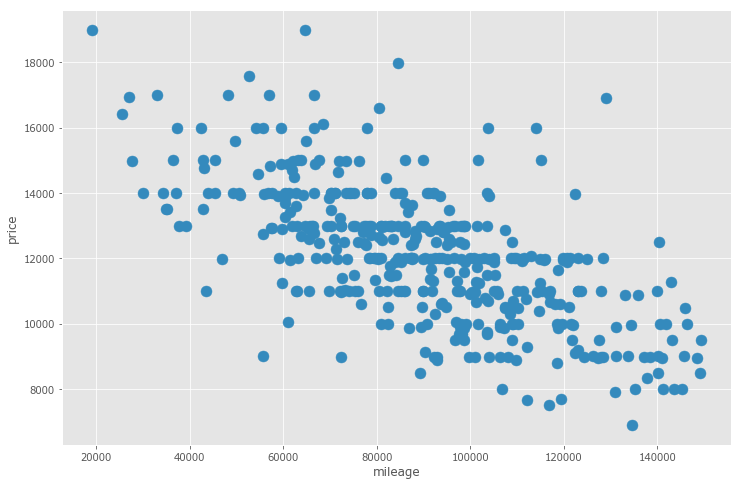

In [5]:
df_train.plot(x='mileage', y='price', kind='scatter', s=120)

Кажется, что между стоимостью и пробегом зависимость линейная - давайте ее найдем!

In [6]:
X_train = df_train.mileage.values.reshape(-1, 1)
y_train = df_train.price.values

In [7]:
from sklearn.linear_model import LinearRegression

Обучим модель

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
print 'Модель:\nprice = %.2f + (%.2f)*mileage' % (model.intercept_, model.coef_[0])

Модель:
price = 16762.02 + (-0.05)*mileage


Нарисуйте предсказание модели (прямую) вместе с данными на плоскости. Здесь можно либо явно взять уравнение прямой и посчитать значения в каждой точке, либо через predict.

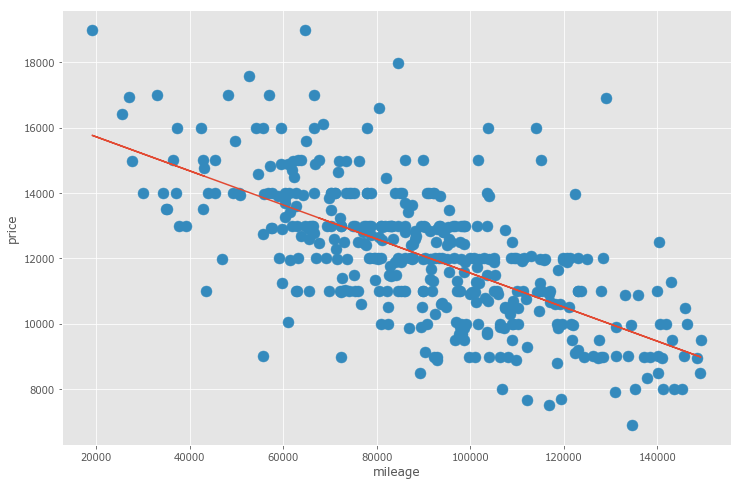

In [10]:
df_train.plot(x='mileage', y='price', kind='scatter', s=120)

y_hat = model.predict(X_train)

plt.plot(X_train, y_hat)

### Меры качества

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Можно посчитать простые варианты агрегирования остатков, например:

* $\frac{1}{n} \sum_i |\hat{y}^{(i)}-y^{(i)}|$ - средняя абсолютная ошибка
* $\frac{1}{n} \sum_i (\hat{y}^{(i)}-y^{(i)})^2$ - средняя квадратичная ошибка

In [12]:
y_hat = model.predict(X_train)

In [13]:
print('Средняя абсолютная ошибка %.2f' % mean_absolute_error(y_train, y_hat))
print('Средняя квадратичная ошибка %.2f' % mean_squared_error(y_train, y_hat))

Средняя абсолютная ошибка 1182.21
Средняя квадратичная ошибка 2412292.55


Можно рассмотреть более сложную меру: коэффициент детерминации $R^2$:

* $TSS = \sum_i (y^{(i)}-\bar{y})^2$ - общая сумма квадратов (total sum of squares)
* $RSS = \sum_i (\hat{y}^{(i)}-y^{(i)})^2$ - сумма квадратов остатков (residual sum of squares)
* $ESS = \sum_i (\hat{y}^{(i)}-\bar{y})^2$ - объясненная сумма квадратов (explained sum of squares)

Для простоты будем считать, что
$$TSS = ESS + RSS$$

Тогда Коэффициент детерминации $R^2=1-\frac{RSS}{TSS}$

Рассчитайте его для нашей модели


## Преобразование переменных

### Нормализация

Переход к близким или единым шкалам улучшает сходимость градиентного спуска, уменьшает риск переполнения разрядности чисел, однако приходится жертвовать прямой интерпретируемостью..

Нормализацию обычно проделывают для вещественных признаков.

Нормализация z-score:
1. Вычитаем среднее: $x - \bar{x}$
2. Делим на стандартное отклонение: $\frac{x - \bar{x}}{std(x)}$

Можно проделать вручную, можно с помошью метода ниже

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LinearRegression(fit_intercept=True)
model.fit(X_train_scaled, y_train)

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
print('Модель:\nprice = %.2f + (%.2f)*mileage`' % (model.intercept_, model.coef_[0]))

Модель:
price = 12084.24 + (-1351.67)*mileage`


## Как обучать линейную регрессию?
Попробуем разобраться без всяких `.predict()` и `.fit()`

### Рассмотрим случай с одним признаком и свободным членом

$X$ - признаковое описание наблюдений,<br\> $y$ - прогнозируемая величина

Пусть задана функция ошибки (функция потерь) $L(\cdot)$. <br\>
Нам надо построить такой функционал $f(X)$, который будет выдавать значение наиболее близкие к $y$, иначе говоря: $$L\left(f(X) - y\right) \rightarrow\min $$

Определим функцию потерь, как сумму квадратов разности выдаваемого ответа функционала и реального значения: 
$$ L(\cdot) = \frac{1}{2n}\sum_{i=1}^n(f(x^{(i)}) - y^{(i)})^2$$

Так как среди всего множества моделей мы выбрали линейную регрессию, то $$f(X) = \beta_0 + \beta_1x_1$$
Подставляем это выражение в $L(\cdot)$ и находим $\beta_0$,
$\beta_1$!

$$ L(\beta_0,\beta_1) = \frac{1}{2n}\sum^{n}_{i=1}(f(x^{(i)})  - y^{(i)})^2 = \frac{1}{2n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})^2  \rightarrow \min\limits_{\beta_0, \beta_1} $$

Изобразим функцию потерь на трехмерном графике в зависимости от $\beta_0$ и $\beta_1$ для задачи с автомобилем

In [16]:
X_train[:10]

array([[ 67697],
       [ 73738],
       [ 80313],
       [ 86096],
       [ 79607],
       [ 96966],
       [126150],
       [119255],
       [ 73513],
       [ 50649]])

In [17]:
# для удобства добавим столбец из "1" в матрицу с признаком "пробег"
X_model = np.c_[np.ones(X_train.shape), X_train]
X_model.shape

(417, 2)

In [18]:
X_model[:10]

array([[  1.00000000e+00,   6.76970000e+04],
       [  1.00000000e+00,   7.37380000e+04],
       [  1.00000000e+00,   8.03130000e+04],
       [  1.00000000e+00,   8.60960000e+04],
       [  1.00000000e+00,   7.96070000e+04],
       [  1.00000000e+00,   9.69660000e+04],
       [  1.00000000e+00,   1.26150000e+05],
       [  1.00000000e+00,   1.19255000e+05],
       [  1.00000000e+00,   7.35130000e+04],
       [  1.00000000e+00,   5.06490000e+04]])

In [19]:
from mpl_toolkits import mplot3d

Text(0,0.5,u'beta_1')

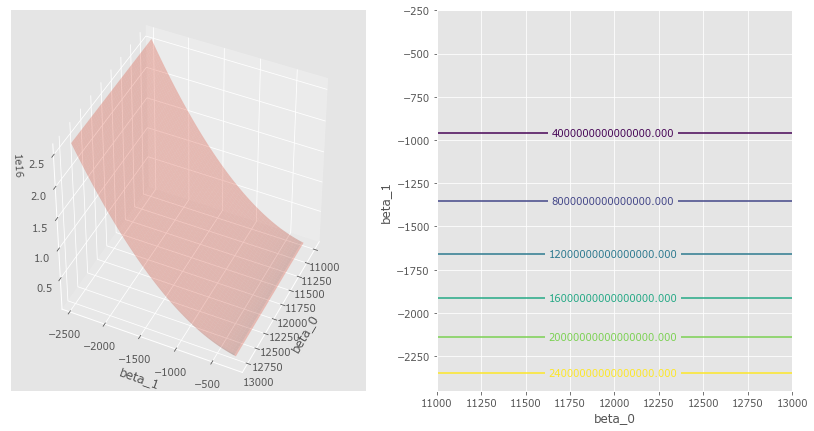

In [20]:
beta0 = np.linspace(11000 , 13000, 100)
beta1 = np.linspace(-2450, -250, 100)

B0, B1= np.meshgrid(beta0, beta1)

B_all = np.c_[B0.reshape(-1,1), B1.reshape(-1,1)].T

L = X_model.dot(B_all) - y_train.reshape(-1,1)
L = L ** 2
L = L.mean(axis=0)/2
L = L.reshape(B0.shape)


fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(40, 25)
ax.plot_surface(B0, B1, L, alpha=0.3,)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')

ax = fig.add_subplot(1, 2, 2)
contour = ax.contour(B0, B1, L)
plt.clabel(contour, inline=1, fontsize=10)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')

### Градиентный спуск

Градиентый спуск - это итеративный метод оптимизации функции. Он заключается в постепенном перемещении к точке экспетмума в направлении антиградиента этой функции в точке.

Посчитаем, чему равен градиент функции потерь $L(\beta_0, \beta_1):$
$$ \frac{\partial L}{\partial \beta_0} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})$$
$$ \frac{\partial L}{\partial \beta_1} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})x_1^{(i)}$$

Иногда проще это записать в виде матриц:
$$ \frac{\partial L}{\partial \beta} = X^\top(X\beta - y)$$

Метод градиентного спуска заключается в итеративном и **одновременном(!!!)** обновлении значений $\beta$ в направлении, противоположному градиенту:
$$ \beta := \beta -  \frac{\alpha}{n} \frac{\partial L}{\partial \beta}$$


Теперь к шагам алгоритма:

* Задаем случайное начальное значение для $\beta$
* Пока не будет достигнуто правило останова:
    * Считаем ошибку и значение функции потерь
    * Считаем градиент
    * Обновляем коэффициенты

In [21]:
def gradient_descent(X, y, iters, alpha):
    
    costs = []
    betas = []
    
    n = y.shape[0] 
    Beta = np.random.rand(X.shape[1])
    for i in range(iters):
        y_hat = X.dot(Beta)
        
        # считаем ошибку и значение функции потерь
        resid = (y_hat - y) # ошибки
        cost = (resid**2).sum()
        
        # считаем градиент
        grad = X.T.dot(resid)

        # обновляем коэффициенты
        Beta = Beta - alpha/n * grad
        
        if (i % 10) == 0:
            betas.append(Beta)
            costs.append(cost)
                    
    return Beta, costs, betas

In [22]:
Beta, costs, betas = gradient_descent(X_model, y_train, 100, 0.05)

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: overflow encountered in square
/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in subtract


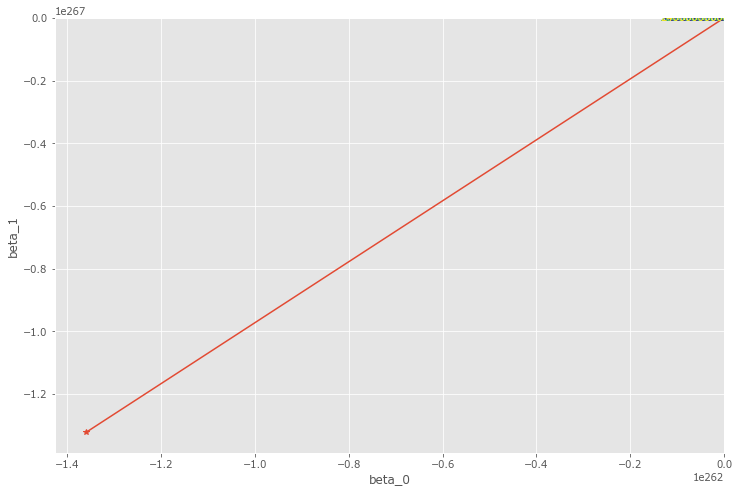

In [23]:
beta0 = np.linspace(11000 , 13000, 100)
beta1 = np.linspace(-2450, -250, 100)

B0, B1= np.meshgrid(beta0, beta1)

B_all = np.c_[B0.reshape(-1,1), B1.reshape(-1,1)].T

L = X_model.dot(B_all) - y_train.reshape(-1,1)
L = L ** 2
L = L.mean(axis=0)/2
L = L.reshape(B0.shape)

fig, ax = plt.subplots(1,1)
contour = ax.contour(B0, B1, L)
plt.clabel(contour, inline=1, fontsize=10)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')

betas = np.array(betas)
ax.plot(betas[:,0], betas[:,1], marker='*')


# Логистическая регрессия

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

## Игрушечный пример

Сгенерируем выборку и опробуем логистическую регрессию

In [27]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) + [2, 2],
          np.random.randn(20, 2) + [-2, -2]]
y = [-1] * 20 + [1] * 20

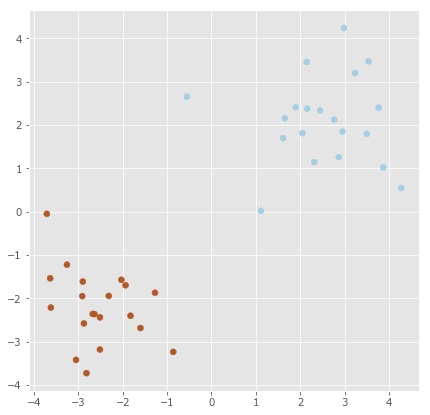

In [28]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0],
           X[:, 1],
           c=y,
           cmap=plt.cm.Paired)

In [29]:
from sklearn.linear_model import LogisticRegression

Обучим логистическую регрессию на этих данных и нарисуем разделяющую гиперплоскость

In [30]:
model = LogisticRegression(C=1.0, 
                           fit_intercept=True, 
                           penalty='l2')
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
print 'w_0 = %f' % model.intercept_
print 'w_1, w_2 = ', model.coef_[0]

w_0 = -0.183954
w_1, w_2 =  [-1.06097157 -1.00171289]


In [ ]:
# Нарисуем эту гиперплоскость


In [33]:
y_hat = model.predict(X)
y_hat[:10]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [34]:
y_hat_proba = model.predict_proba(X)
y_hat_proba[:10, :]

array([[  9.98616528e-01,   1.38347180e-03],
       [  9.99496019e-01,   5.03981209e-04],
       [  9.95091160e-01,   4.90883960e-03],
       [  9.94323473e-01,   5.67652674e-03],
       [  9.90157090e-01,   9.84290974e-03],
       [  9.97319087e-01,   2.68091305e-03],
       [  9.94720579e-01,   5.27942062e-03],
       [  9.94026880e-01,   5.97312006e-03],
       [  9.96628393e-01,   3.37160720e-03],
       [  9.77815343e-01,   2.21846572e-02]])

In [35]:
dec_func = model.decision_function(X)
dec_func[:10]

array([-6.58177471, -7.59246747, -5.31179677, -5.16572302, -4.61111223,
       -5.91891334, -5.23864551, -5.11449484, -5.68898843, -3.78591991])

### Как сделать нелинейную границу?

Рассмотрим набор данных, который в простонародье называют "Бублик".

In [36]:
from sklearn.datasets import make_circles

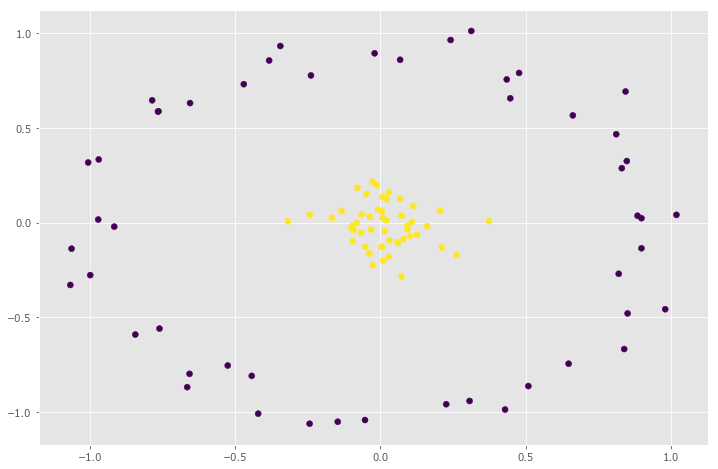

In [37]:
X, y = make_circles(n_samples=100, shuffle=True,
                    noise = 0.1,
                    factor=0.1)

plt.scatter(X[:, 0],
            X[:, 1],
            c=y)

Очевидно, что классы нельзя разделить линией. Но можно сделать это окружностью! </br>
Т.е. разделяющся линия теперь будет задаваться не уравнением прямой $g(x) = w_0 + w_1x_1 + w_2x_2$, а уравнением окружности. 

Выполните преобразование матрицы X, чтобы в ней были столбцы для $x_1$, $x_2$, $x^2_1$ + $x^2_2$ и обучите логистическую регрессию.

In [39]:
# Your code Here
X_new = np.c_[X, X[:,0]**2 + X[:,1]**2]
model = LogisticRegression(C=100000, 
                           fit_intercept=True)
model.fit(X_new, y)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [40]:
X_new[:10]

array([[ 0.6628582 ,  0.566528  ,  0.76033498],
       [ 1.01976426,  0.04139   ,  1.04163229],
       [ 0.11345315,  0.08853271,  0.02070966],
       [-0.02778909,  0.21590001,  0.04738505],
       [ 0.09266786, -0.01594095,  0.00884145],
       [ 0.00524132, -0.12529629,  0.01572663],
       [ 0.4776595 ,  0.79054453,  0.85311925],
       [-0.24323304,  0.04272888,  0.06098807],
       [-0.2439184 , -1.06114425,  1.1855233 ],
       [ 0.89929878,  0.02373896,  0.80930184]])

In [41]:
# Посчитаем количество ошибок
y_hat = model.predict(X_new)
(y != y_hat).sum()

0

In [42]:
# Нарисуем полученную окружность

x0, x1 = np.meshgrid(np.arange(-1.5, 1.5, 0.1),
                       np.arange(-1.5, 1.5, 0.1))
xx0, xx1 = x0.ravel(), x1.ravel()

# Your code here

## Анализ тональности

Загрузите текстовые данные [отсюда](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/). Архив должен содержать 3 файла с положительными и отрицательными отзывами с ресурсов
* imdb.com
* amazon.com
* yelp.com

Формат файла следующий:
<отзыв>\t<метка>\n


### Задача
1. Загрузите тексты и метки классов в разные переменные
2. Выберите меру качества классификации
3. Обучите логистическую (без подбора гиперпараметров). Тексты представляются в виде мешка слов
4. Выведите наиболее значимые слова из текста

In [24]:
!ls sentiment/

amazon_cells_labelled.txt readme.txt
imdb_labelled.txt         yelp_labelled.txt


In [25]:
sent_data = pd.read_csv('sentiment/imdb_labelled.txt', 
                        sep='\t', 
                        names=['sentence', 'label'], header=None)

In [26]:
sent_data.head()

,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [27]:
sent_data.shape

(748, 2)

In [28]:
X = sent_data.sentence.values
y = sent_data.label.values

In [29]:
X[:5]

array([ 'A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  ',
       'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  ',
       'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  ',
       'Very little music or anything to speak of.  ',
       'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  '], dtype=object)

In [30]:
y[:5]

array([0, 0, 0, 0, 1])

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
vect = CountVectorizer(max_df=0.95, analyzer=u'word',
                       min_df=3,
                       ngram_range=(2, 2), 
                       stop_words='english')

In [33]:
vect.fit(X)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(2, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [34]:
vect.transform(X)

<748x57 sparse matrix of type '<type 'numpy.int64'>'
	with 208 stored elements in Compressed Sparse Row format>

In [35]:
words = vect.get_feature_names()

In [36]:
len(words)

57

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
model = Pipeline([
    ('vect', vect),
    ('clf', LogisticRegression())
])

In [39]:
model.fit(X, y)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(2, 2), preprocessor=None, stop_words='english',
    ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [40]:
y_hat = model.predict_proba(X)

In [41]:
weights = model.steps[1][1].coef_
words = model.steps[0][1].get_feature_names()

In [42]:
coefs = pd.Series(index=words, data=weights[0])

In [43]:
coefs.sort_values()

waste time               -1.397528
just didn                -0.933206
acting bad               -0.929424
90 minutes               -0.899509
cover girl               -0.899509
really bad               -0.837326
film bad                 -0.817301
hour half                -0.765411
bad script               -0.718757
special effects          -0.671102
movies ve                -0.667440
avoid costs              -0.612264
ve seen                  -0.602955
bad film                 -0.594383
don waste                -0.568558
story line               -0.538280
film just                -0.487419
time film                -0.308357
didn really              -0.223502
looked like              -0.187990
good actors              -0.138866
bad bad                  -0.026722
camera work              -0.025713
don think                 0.087009
worth seeing              0.105330
watching film             0.143233
great director            0.211604
black white               0.264792
great film          

In [44]:
y_hat[:10]

array([[ 0.48714582,  0.51285418],
       [ 0.48714582,  0.51285418],
       [ 0.42159725,  0.57840275],
       [ 0.48714582,  0.51285418],
       [ 0.31213701,  0.68786299],
       [ 0.48714582,  0.51285418],
       [ 0.48714582,  0.51285418],
       [ 0.48714582,  0.51285418],
       [ 0.48714582,  0.51285418],
       [ 0.48714582,  0.51285418]])

# Sberbank DS Contest

В этом задании мы рассмотрим данные с предыдущего Sberbank Data Science Contest. К сожалению найти страницу с конкурсом уже не получается.

Одной из задач была опредление пола владельца карты по его транзакциям на карте. Зачем это нужно - одному сберу известно, но эта задача была хороша тем, что в ней можно нагенерировать много разных признаков

Есть такая [презентация](https://alexanderdyakonov.files.wordpress.com/2016/10/dj2016_sdsj_vis.pdf) с предварительным анализом данных и идеями про признаки

Нам понадобятся файлы `customers_gender_train.csv`, `transactions.tsv.gz`, `mcc_types.tsv` и `trans_types.tsv`.

## Посмотрим на данные

Это метки ответов

In [45]:
df_gender = pd.read_csv('data/customers_gender_train.csv')
df_gender.head()

,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


Это сами транзакции (отрицательные транзакции - списывание, положительные - зачисление на счет)

In [46]:
df_transactions = pd.read_csv('data/transactions.csv.gz')
df_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


Далее, расшифровки кодов [mcc](https://ru.wikipedia.org/wiki/Merchant_Category_Code) и транзакций

In [47]:
df_tr = pd.read_csv('data/tr_types.csv', sep=';', encoding='utf8')
df_tr.head()

,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [48]:
df_mcc = pd.read_csv('data/tr_mcc_codes.csv', sep=';', encoding='utf8')
df_mcc.head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


Первое что мы видем - это странная дата и суммы в транзакциях. 

В принципе, посмотрев на исходное распределение "относительных" дат по какой-нибудь гендерной группы mcc, становится примерно понятно, что за даты закодированы.

Ну а суммы транзакций организаторы просто умножили на $\pi^{\exp}$ =)

Преобразование будет проделано ниже, но при желании, можете сами со всем разобраться.

In [49]:
from pandas import Timestamp, DateOffset

In [50]:
def preproc_transactions(df_transactions):
    sec_per_day = 86400
    sec_per_hour = 3600
    
    start_date = 1420070400 - 154 * sec_per_day - 3 * sec_per_hour
    
    df_transactions.loc[:, 'day'] = df_transactions.tr_datetime\
                                               .str.split(' ')\
                                               .str.get(0)\
                                               .astype(int)
    df_transactions.loc[:, 'time_raw'] = df_transactions.tr_datetime\
                                                    .str.split(' ')\
                                                    .str.get(1)

    # set temp dt
    df_transactions.loc[:, 'dt_temp'] = pd.to_datetime(df_transactions.loc[:, 'time_raw'], 
                                                    format='%H:%M:%S')\
                                        + DateOffset(years=115)
    
    df_transactions = df_transactions.assign(dt = lambda x: x.dt_temp.astype(np.int64) // 10**9
                                             + (x.day - 153) * sec_per_day)\
                                     .assign(weekday = lambda x: ((x.day + 4) % 7 + 1))
        
    df_transactions.loc[:, 'datetime'] = pd.to_datetime(df_transactions.dt, unit='s')
    df_transactions.loc[:, 'date'] = df_transactions.loc[:, 'datetime'].dt.strftime('%Y-%m-%d')
    df_transactions.loc[:, 'hour'] = df_transactions.loc[:, 'datetime'].dt.strftime('%H')
    
    df_transactions = df_transactions.drop(['dt_temp', 'time_raw', 'tr_datetime'], axis=1)
    
    df_transactions.loc[:, 'amount'] = np.round(df_transactions.loc[:, 'amount']/(np.pi**np.exp(1)))
            
    return df_transactions

In [51]:
df_transactions = df_transactions.pipe(preproc_transactions)

In [52]:
df_transactions.head()

,customer_id,mcc_code,tr_type,amount,term_id,day,dt,weekday,datetime,date,hour
0,39026145,4814,1030,-100.0,NaN,0,1406888606,5,2014-08-01 10:23:26,2014-08-01,10
1,39026145,6011,7010,2500.0,NaN,1,1406974769,6,2014-08-02 10:19:29,2014-08-02,10
2,39026145,4829,2330,-2500.0,NaN,1,1406974856,6,2014-08-02 10:20:56,2014-08-02,10
3,39026145,5499,1010,-62.0,NaN,1,1406975994,6,2014-08-02 10:39:54,2014-08-02,10
4,39026145,5499,1010,-41.0,NaN,2,1407080022,7,2014-08-03 15:33:42,2014-08-03,15


## Генерим признаки

* Для котого мы делаем предсказания?
* Какие признаки этих объектов мы можем рассчитать?

In [53]:
df_transactions.head()

,customer_id,mcc_code,tr_type,amount,term_id,day,dt,weekday,datetime,date,hour
0,39026145,4814,1030,-100.0,NaN,0,1406888606,5,2014-08-01 10:23:26,2014-08-01,10
1,39026145,6011,7010,2500.0,NaN,1,1406974769,6,2014-08-02 10:19:29,2014-08-02,10
2,39026145,4829,2330,-2500.0,NaN,1,1406974856,6,2014-08-02 10:20:56,2014-08-02,10
3,39026145,5499,1010,-62.0,NaN,1,1406975994,6,2014-08-02 10:39:54,2014-08-02,10
4,39026145,5499,1010,-41.0,NaN,2,1407080022,7,2014-08-03 15:33:42,2014-08-03,15


In [54]:
def gen_features(df_gender, df_transactions):
    df_mcc_features = \
    df_transactions.query('amount < 0')\
           .pivot_table(index='customer_id', aggfunc='mean',
                        values='amount', 
                        columns=['mcc_code'])\
           .rename_axis(lambda x: 'mcc_code={}'.format(x), axis=1)
            
    df_weekday_features = \
    df_transactions.query('amount < 0')\
                   .pivot_table(index='customer_id',
                                aggfunc='count',
                                columns=['weekday'],
                                values='amount')

    total = df_weekday_features.sum(axis=1) 
    
    df_weekday_features = ((df_weekday_features.T)/total).T
    
    df_features = df_gender.join(df_mcc_features, 
                                 on='customer_id', 
                                 how='left')\
                           .join(df_weekday_features, 
                                 on='customer_id', 
                                 how='left')\
                           .fillna(0.0)
    
    return df_features

In [55]:
df_features = df_gender.pipe(gen_features, df_transactions)

In [56]:
df_features.head()

,customer_id,gender,mcc_code=742,mcc_code=1711,mcc_code=1731,mcc_code=1799,mcc_code=2741,mcc_code=3000,mcc_code=3351,mcc_code=3501,...,mcc_code=9311,mcc_code=9399,mcc_code=9402,1,2,3,4,5,6,7
0,75562265,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.156134,0.122677,0.159851,0.130112,0.171004,0.118959,0.141264
1,10928546,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1740.0,0.0,0.159544,0.170940,0.118234,0.185185,0.158120,0.099715,0.108262
2,69348468,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.150115,0.150115,0.133949,0.131640,0.173210,0.131640,0.129330
3,84816985,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.189189,0.189189,0.229730,0.121622,0.040541,0.135135,0.094595
4,61009479,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.133152,0.160326,0.171196,0.138587,0.152174,0.125000,0.119565


In [57]:
X = df_features.iloc[:, 2:].values
y = df_features.iloc[:, 1].values

## Подбор гипер-параметров

### Pipeline

Сделаем простой sklearn пайплайн, который делает следующее:
* Нормирует признаки через StandartScaler
* Запускает лог-регрессию

In [58]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.linear_model import LogisticRegression

In [59]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

In [60]:
RND_SEED = 123

До этого мы исключительно смотрели, как влияет на меру качества какой-то один параметр при фиксированных остальных. Пришло время перебирать все что можно!

В базовом варианте, это делается либо через `Grid Search`, либо через `Random Search`. Какие ключевые отличия?
* В `Grid Search` вы в явнов виде задаете возможные значения каждого гипер-параметра, который хотите варьировать. Соответственно, выполняется **полный** перебор всех возможных комбинаций
* В `Random Search` допукается указание распределения параметров, например "равномерно, на интервале от 0 до 100" или "нормальное распределение с таким-то цетром и такой-то дисперсией. Соответственно, так как это случайный перебор, то **вы** просто **задаете** количество случайных комбинаций, которые будут проверяться

Может показаться, что делать случайный перебор опасно - там же все случайно. Но на практике именно он и искользуется в силу двух причин
* Полный перебор большого количества комбинаций очень долгий
* Мы можем просто пропустить значения гиперпараметра, которые сильно влияют на метрику качества (см рисунок снизу)

<img src='images/gridsearch.jpeg'>

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [62]:
from scipy.stats import lognorm as sp_lognorm

In [63]:
cv = StratifiedKFold(n_splits=5, 
                     random_state=RND_SEED, shuffle=True)

In [64]:
param_grid = {
    'scaler__with_mean': [False, True],
    'clf__penalty': ['l2'],
    'clf__random_state': [RND_SEED],
    'clf__C': sp_lognorm(3)
}

random_searcher = RandomizedSearchCV(model, param_grid, n_iter=100, 
                                     random_state=RND_SEED,
                                     scoring='roc_auc', 
                                     n_jobs=1, cv=cv, 
                                     verbose=2)

random_searcher.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0385079020806, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=19.9262177551, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=19.9262177551, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=19.9262177551, clf__random_state=123, scaler__with_mea

[CV]  clf__penalty=l2, clf__C=87.7216627328, clf__random_state=123, scaler__with_mean=True, total=   1.0s
[CV] clf__penalty=l2, clf__C=87.7216627328, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=87.7216627328, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=87.7216627328, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=87.7216627328, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=0.147090683175, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=0.147090683175, clf__random_state=123, scaler__with_mean=True, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.147090683175, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=0.147090683175, clf__random_state=123, scaler__with_mean=True, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.147090683175, clf__random_state=123, scaler__with_mean=True 
[CV]  clf_

[CV]  clf__penalty=l2, clf__C=0.0232455397689, clf__random_state=123, scaler__with_mean=True, total=   0.6s
[CV] clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.147599241258, clf__random_state=123, scaler__with_mean=Fa

[CV]  clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False, total=   0.5s
[CV] clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False, total=   0.5s
[CV] clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False, total=   0.5s
[CV] clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=7.88268146409, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=0.355608429795, clf__random_state=123, scaler__with_mean=False 
[CV]

[CV]  clf__penalty=l2, clf__C=824.213843865, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=824.213843865, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=824.213843865, clf__random_state=123, scaler__with_mean=False, total=   0.6s
[CV] clf__penalty=l2, clf__C=824.213843865, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=824.213843865, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=0.114919040566, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=0.114919040566, clf__random_state=123, scaler__with_mean=True, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.114919040566, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=0.114919040566, clf__random_state=123, scaler__with_mean=True, total=   0.7s
[CV] clf__penalty=l2, clf__C=0.114919040566, clf__random_state=123, scaler__with_mean=True 
[CV] 

[CV]  clf__penalty=l2, clf__C=10.8545896893, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=0.0728649966332, clf__random_state=123, scaler__with

[CV]  clf__penalty=l2, clf__C=4.79450381391, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=4.79450381391, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=4.79450381391, clf__random_state=123, scaler__with_mean=True, total=   1.0s
[CV] clf__penalty=l2, clf__C=4.79450381391, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=4.79450381391, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=4.79450381391, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=4.79450381391, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=252.925667477, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=252.925667477, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=252.925667477, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__p

[CV]  clf__penalty=l2, clf__C=0.0812094867476, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=0.0812094867476, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0812094867476, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0812094867476, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0812094867476, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=3.97337562749, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=3.97337562749, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=3.97337562749, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=3.97337562749, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=3.97337562749, clf__random_state=123, scaler__with_mean=Fa

[CV]  clf__penalty=l2, clf__C=30.6696856181, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=1.67255988757, clf__random_state=123, scaler__with_mean=False 
[CV]  

[CV]  clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0594953723746, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=3.59103305109, clf__random_state=123, scaler__with

[CV]  clf__penalty=l2, clf__C=0.0948823325257, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0948823325257, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0948823325257, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0948823325257, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0948823325257, clf__random_state=123, scaler__with_mean=False, total=   0.3s
[CV] clf__penalty=l2, clf__C=0.0948823325257, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=0.0948823325257, clf__random_state=123, scaler__with_mean=False, total=   0.2s
[CV] clf__penalty=l2, clf__C=357.177917922, clf__random_state=123, scaler__with_mean=False 
[CV]  clf__penalty=l2, clf__C=357.177917922, clf__random_state=123, scaler__with_mean=False, total=   0.4s
[CV] clf__penalty=l2, clf__C=357.177917922, clf__random_state=123, scaler__with_mea

[CV]  clf__penalty=l2, clf__C=0.671235560568, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=0.671235560568, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=0.671235560568, clf__random_state=123, scaler__with_mean=True, total=   0.8s
[CV] clf__penalty=l2, clf__C=0.671235560568, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=0.671235560568, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=4.14972428056, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=4.14972428056, clf__random_state=123, scaler__with_mean=True, total=   1.0s
[CV] clf__penalty=l2, clf__C=4.14972428056, clf__random_state=123, scaler__with_mean=True 
[CV]  clf__penalty=l2, clf__C=4.14972428056, clf__random_state=123, scaler__with_mean=True, total=   0.9s
[CV] clf__penalty=l2, clf__C=4.14972428056, clf__random_state=123, scaler__with_mean=True 
[CV]  clf_

[CV]  clf__penalty=l2, clf__C=0.00395798874384, clf__random_state=123, scaler__with_mean=True, total=   0.4s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'clf__penalty': ['l2'], 'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a528d4650>, 'clf__random_state': [123], 'scaler__with_mean': [False, True]},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [65]:
random_searcher.best_params_

{'clf__C': 0.020151694020222502,
 'clf__penalty': 'l2',
 'clf__random_state': 123,
 'scaler__with_mean': True}

In [66]:
random_searcher.best_score_

0.75090209130517616

In [68]:
random_searcher.grid_scores_

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.75059, std: 0.01171, params: {'clf__penalty': 'l2', 'clf__C': 0.038507902080624053, 'clf__random_state': 123, 'scaler__with_mean': False},
 mean: 0.75011, std: 0.01184, params: {'clf__penalty': 'l2', 'clf__C': 19.926217755070205, 'clf__random_state': 123, 'scaler__with_mean': False},
 mean: 0.75011, std: 0.01184, params: {'clf__penalty': 'l2', 'clf__C': 184.03213694178385, 'clf__random_state': 123, 'scaler__with_mean': True},
 mean: 0.75013, std: 0.01185, params: {'clf__penalty': 'l2', 'clf__C': 3.385028383633593, 'clf__random_state': 123, 'scaler__with_mean': True},
 mean: 0.74356, std: 0.01075, params: {'clf__penalty': 'l2', 'clf__C': 0.00068915956108850243, 'clf__random_state': 123, 'scaler__with_mean': False},
 mean: 0.75028, std: 0.01178, params: {'clf__penalty': 'l2', 'clf__C': 0.27617021383351631, 'clf__random_state': 123, 'scaler__with_mean': False},
 mean: 0.75035, std: 0.01191, params: {'clf__penalty': 'l2', 'clf__C': 0.26123832647699602, 'clf__random_state': 123, 's